# Assignment 3 - Quantum Communication

### <span style="color:#61c2e8">Task 2</span>: Quantum Teleportation with Fixup (Quantinuum)

In tasks 2 and 3 we will explore quantum teleportation - a protocol for moving quantum information. As we will see, the limitations of the targets on which we want to run the protocol will impact the implementation of the protocol. To start with, we will implement the standard teleportation scheme and run it on the Quantinuum simulator.

#### Run these cells before beginning to import necessary packages.
This cell may take a minute or more to complete. Importing qsharp triggers a sequence of actions which allow us to compile and run Q# code in this notebook.

In [1]:
import qsharp
import qsharp.azure
import matplotlib.pyplot as plt

Preparing Q# environment...
.

In [2]:
%%qsharp
open Microsoft.Quantum.Diagnostics; 
open Microsoft.Quantum.Measurement;
open Microsoft.Quantum.Canon;
open Microsoft.Quantum.Arrays;
open Microsoft.Quantum.Random;

The first part of quantum teleportation is the creation of a Bell pair. Let's implement an operation to prepare it.

In [3]:
%%qsharp
/// # Summary
/// Prepares a Bell state on a 2 qubit array
///
/// # Input
/// ## qs
/// The array that is being acted on

operation BellStatePrep(qs : Qubit[]) : Unit {
    H(qs[0]);
    CNOT(qs[0], qs[1]);
}

Next we will distribute our Bell pair to two parties, the sender and receiver. In order to do this, let's create the `Sender` and `Receiver` operations. The sender will need to send 2 bits of classical information to the receiver to perform teleportation.

The flow of the teleportation protocol is as follows:
1. The sender and the receiver each obtain a single qubit from a Bell pair, prepared by a third party.
2. The sender entangles her qubit with the qubit she wishes to teleport and performs Bell state measurement.
3. The receiver performs one of the 4 different operations on his qubit depending on the results of the sender's measurement.
4. The receiver now has a qubit with the state the sender wanted to teleport!

In [4]:
%%qsharp
/// # Summary
/// Takes a qubit and applies an Ry to it.
///
/// # Input
/// ## q
/// The input qubit

operation StatePrepare(q : Qubit) : Unit is Adj {
    Ry(3.1415 / 7.0, q);
}

/// # Summary
/// In this operation the sender will take her half of the Bell state
/// and entangle it with the qubit she wishes to teleport. 
/// Lastly she will perform Bell state measurement.
/// 
/// # Input
/// ## q
/// The sender's qubit from the initial shared Bell state.
///
/// # Output
/// A tuple of two Results, one for each result in the Bell state measurement.

operation Sender(q : Qubit) : (Result, Result) {
    use qSend = Qubit();
    // Prepare the state to transmit
    StatePrepare(qSend);
    
    // Perform Bell state measurement 
    CNOT(qSend, q);
    H(qSend);
    return (M(qSend), M(q));
}

/// # Summary
/// In this operation the receiver performs one of 4 operations depending
/// on the results of the sender's Bell state measurement.
///
/// # Input
/// ## q
/// This is the receiver's share of the Bell state
/// ## (first, second) 
/// The tuple of the sender's measurement results.

operation Receiver(q : Qubit, (first : Result, second : Result)): Unit {
    // This splits the tuple into two variables
    if second == One { 
        X(q);
    }
    if first == One {
        Z(q);
    }
}

Now let us implement the top-level operation that prepares the Bell state, passes their qubits to the sender and the receiver, and performs their parts of the protocol.

In [15]:
%%qsharp
/// # Summary
/// This is the top-level operation for the teleportation routine.
/// It allocates qubits and prepares the initial Bell pair which the sender 
/// and receiver will share, and then performs the teleportation protocol.
///
/// # Output
/// A single result obtained by measuring the qubit that had a state
/// teleported to it. Before measurement we apply the adjoint of StatePrepare to
/// this qubit, so we will measure |0⟩ if the state was teleported successfully.

operation Teleport() : Result {
    use qs = Qubit[2];
    BellStatePrep(qs);
    let result = Sender(qs[0]);
    Receiver(qs[1], result);

    // Apply the adjoint of the StatePrepare operation.
    // If we teleport the state properly, we will always measure |0⟩,
    // otherwise we'll measure |1⟩ part of the time.
    Adjoint StatePrepare(qs[1]);
    return M(qs[1]);
}

Let's first simulate things to see what is happening in the ideal case.

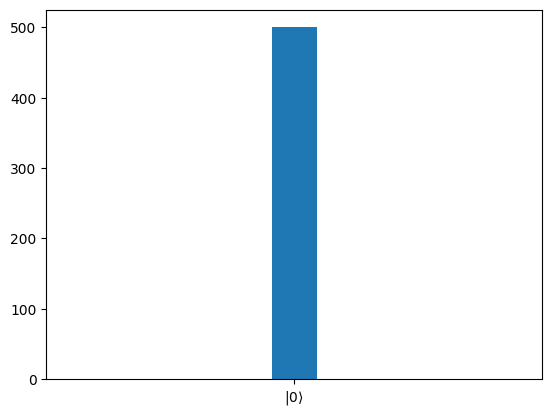

In [16]:
result = []
for shot in range(500):
    result.append(Teleport.simulate())
fig, ax = plt.subplots()
ax.set_xticks([0], labels=[r"$|0\rangle$"])
plt.hist(result, bins=[-1, -0.1, 0.1, 1])
plt.show()

Notice how we always measure $|0\rangle$. This means the sender successfully teleported the state.

Next let's submit this job to the Quantinuum noisy simulator to see how noise affects the performance of teleportation.

In [17]:
qsharp.azure.connect(
   resourceId="/subscriptions/476fe4b3-6f35-4af3-8050-b3b41a795058/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/IntroToQuantumProj",
   location="East US")

Connecting to Azure Quantum...

Authenticated using Microsoft.Azure.Quantum.Authentication.TokenFileCredential


Connected to Azure Quantum workspace IntroToQuantumProj in location eastus.


[{'id': 'ionq.qpu', 'current_availability': {}, 'average_queue_time': 40382},
 {'id': 'ionq.qpu.aria-1', 'current_availability': {}, 'average_queue_time': 1671425},
 {'id': 'ionq.simulator', 'current_availability': {}, 'average_queue_time': 2},
 {'id': 'microsoft.estimator', 'current_availability': {}, 'average_queue_time': 0},
 {'id': 'quantinuum.hqs-lt-s1', 'current_availability': {}, 'average_queue_time': 0},
 {'id': 'quantinuum.hqs-lt-s1-apival', 'current_availability': {}, 'average_queue_time': 0},
 {'id': 'quantinuum.hqs-lt-s2', 'current_availability': {}, 'average_queue_time': 222021},
 {'id': 'quantinuum.hqs-lt-s2-apival', 'current_availability': {}, 'average_queue_time': 0},
 {'id': 'quantinuum.hqs-lt-s1-sim', 'current_availability': {}, 'average_queue_time': 20},
 {'id': 'quantinuum.hqs-lt-s2-sim', 'current_availability': {}, 'average_queue_time': 8790},
 {'id': 'quantinuum.hqs-lt', 'current_availability': {}, 'average_queue_time': 0},
 {'id': 'quantinuum.qpu.h1-1', 'current_

In [18]:
qsharp.azure.target("quantinuum.hqs-lt-s1-sim")

Loading package Microsoft.Quantum.Providers.Honeywell and dependencies...
Active target is now quantinuum.hqs-lt-s1-sim


{'id': 'quantinuum.hqs-lt-s1-sim', 'current_availability': {}, 'average_queue_time': 20}

In [19]:
qsharp.azure.submit(Teleport, shots=500, jobName="Teleportation")

Submitting Teleport to target quantinuum.hqs-lt-s1-sim...
Job successfully submitted.
   Job name: Teleportation
   Job ID: e668e37c-c57a-4dc1-a912-29374da6b74f


{'id': 'e668e37c-c57a-4dc1-a912-29374da6b74f', 'name': 'Teleportation', 'status': 'Waiting', 'uri': 'https://portal.azure.com/#@microsoft.onmicrosoft.com/resource/subscriptions/476fe4b3-6f35-4af3-8050-b3b41a795058/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/IntroToQuantumProj/job_management?microsoft_azure_quantum_jobid=e668e37c-c57a-4dc1-a912-29374da6b74f', 'provider': 'quantinuum', 'target': 'quantinuum.hqs-lt-s1-sim', 'creation_time': '2022-12-09T03:18:17.1453986+00:00', 'begin_execution_time': None, 'end_execution_time': None, 'cost_estimate': ''}

In [22]:
qsharp.azure.status()

{'id': 'e668e37c-c57a-4dc1-a912-29374da6b74f', 'name': 'Teleportation', 'status': 'Waiting', 'uri': 'https://portal.azure.com/#@microsoft.onmicrosoft.com/resource/subscriptions/476fe4b3-6f35-4af3-8050-b3b41a795058/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/IntroToQuantumProj/job_management?microsoft_azure_quantum_jobid=e668e37c-c57a-4dc1-a912-29374da6b74f', 'provider': 'quantinuum', 'target': 'quantinuum.hqs-lt-s1-sim', 'creation_time': '2022-12-09T03:18:17.1453986+00:00', 'begin_execution_time': None, 'end_execution_time': None, 'cost_estimate': ''}

In [23]:
qsharp.azure.output()

Result,Frequency,Histogram
0,0.5760000000000004,
1,0.4240000000000003,


### <span style="color:#61c2e8">Task 2 Questions</span>:
* T2.1. What should we expect from the output of the job? What do we actually see?


By compiling the ideal teleportation structure outlined above through the use if a Bell pair we see that the frequency is split about evenly between $\ket{0}$ and $\ket{1}$ but ideally the frequency should be concentrated at $\ket{0}$. The ideal result is also shown above where it displays the frequency being concentrated at $\ket{0}$.

Next switch to the Assignment_3_Task3.ipynb file to continue with assignment 3. 